# Problem Set 2

## Important information

Please submit the single Jupyter Notebook file, where only Python and Markdown/LaTeX are used. Any hand-written solutions inserted by photos or in any other way are prohibitive and will not be graded. If you will have any questions about using Markdown, ask them!

The works will be checked for plagiarism. The score will be divided by the number of similar works.

## Tensor Train (10 pts)

Tensor is a multidimensional array of shape $n_1 \times n_2 \times ... \times n_d$ where the number $d$ defines the dimensionality and every element can be get trough a multi-index $[1_1, i_2, \dots, i_d]$. If $d=1$ such tensor is simply a vector and if $d=2$ - a matrix.

Tensor Train is a special format enables to efficently store high-dimensional tensors and perform mathematical operation with them. It was proposed in [link](https://www.researchgate.net/profile/Ivan-Oseledets/publication/220412263_Tensor-Train_Decomposition/links/5bbfb5c5299bf1004c5a56e3/Tensor-Train-Decomposition.pdf). Basically instead of to direct store elements $A[1_1, i_2, \dots, i_d]$ it was proposed to use a special factorization trough specific 3D-tensors $G_i$ of shape $r_{i-1} \times n_i \times r_i$ that are called **cores**:

$$
A[i_1, i_2, \dots, i_d] =
\sum_{\alpha_0=1}^{r_0}
\sum_{\alpha_1=1}^{r_1}
\dots
\sum_{\alpha_d=1}^{r_d}
G_1[\alpha_0, i_1, \alpha_1] \; \cdot
G_2[\alpha_1, i_2, \alpha_2] \; \cdot
\dots \; \cdot
G_d[\alpha_{d-1}, i_d, \alpha_d],
$$

To construct the cores one needs to perform a TT-SVD algorithm, namely to:
1. Start from the first _unfolding matrix_ of $A$: $C_1 = A.reshape(n_1, \prod_{i=2}^{d} n_i)$.
2. Perform a low-rank SVD for $C_1$ and get the matrices $U_1, \Sigma_1, V_1^*$ with rank $r_1 <= \text{rank}(C_1)$.
3. Compute the core $G_1 = U_1.reshape(r_0, n_1, r_1)$.
4. Update the matrix $C_1 \mapsto C_2 = S_1 V_1^*$.
5. Repeat steps 2-5 for the updated matrices $C$ untill we get all the cores.

**Task (10 pts):** Realize TT-SVD for $d$-dimensional tensor and check it for a random tensor.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def tt_svd(tensor, max_rank=10):
    """
    Convert a tensor into a tensor train.
    input : tensor - np.array of shape [n_1, n_2, ..., n_d]
            max_rank - maximal number that ranks r_0, ..., r_d can reach
    output: cores - list of d np.arrays of shape [r_i-1, n_i, r_i] for i in d
    """
    cores - # YOUR CODE
    return cores

To check your algorithm you need to take a function `tt_to_tensor` that converts a tensor train back into a tensor, run it for a tensor train $\mathcal{A}$ that you would get from your original tensor $A$, and compare $A$ and $A'$ in terms of low-rank approximation error and memory.

In [ ]:
def tt_to_tensor(cores):
    """
    Convert a tensor train into a tensor.
    input : cores - list of d np.arrays of shape [r_i-1, n_i, r_i] for i in d
    output: tensor - np.array of shape [n_1, ..., n_d]
    """
    tensor = cores[0]
    for G in cores[1:]:
        tensor = np.tensordot(tensor, G, 1)
    return tensor[0, ..., 0]

In [ ]:
d = 5
max_mode = 10
modes = np.random.randint(1, max_mode, size=(d))
A = np.random.randn(*modes)

error = []
memory = []
for max_rank in range(1, 50):
    A_tt = tt_svd(A, max_rank)
    A_recovered = tt_to_tensor(A_tt)

    error.append(np.linalg.norm(A_recovered - A))
    memory.append(sum([np.prod(core.shape) for core in A_tt]))

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('MSE')
plt.plot(error)

plt.subplot(1, 2, 2)
plt.title('Memory')
plt.plot(memory)

plt.show()

What can you say about the results?

## Sparce Matrix Factorization for Linear Systems (13 pts)

### Imports

In [ ]:
import numpy as np
import scipy.sparse as sp
import timeit
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin
import matplotlib.pyplot as plt
import time
import networkx as nx
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline

In [ ]:
!apt-get install libsuitesparse-dev
!pip install scikit-sparse
!apt-get install -y ffmpeg imagemagick

In [ ]:
from sksparse.cholmod import cholesky

### Demonstration: Fill-in importance

- Strictly regular matrices have LU-decomposition.

- An important **subclass** of strictly regular matrices is the class of **Hermitian positive definite matrices**


**Definition.** A matrix $A$ is called **positive definite** </font> if for any $x: \Vert x \Vert \ne 0$ we have

$$
(x, Ax) > 0.
$$

- **Claim:** A Hermitian positive definite matrix $A$ is strictly regular and has **Cholesky factorization** of the form

$$A = LL^*,$$

where $L$ is a lower triangular matrix.

Let us see how Cholesky is faster than LU in symmetric positive definite case. First demonstration is a random SPD matrix. The second one is the same matrix, but with its rows and columns permuted to reduce the fill-in.

In [ ]:
n = 3000
ex = np.ones(n)
A = sp.spdiags(np.vstack((3*ex,  7*ex, 3*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(3000,3000, density=(1/(10*n))).tocsr())
A = A+ S.transpose() + S

In [ ]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A, ordering_method="natural")
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc(), permc_spec="NATURAL")
dt = time.time()

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(factor.L())
axes[1].set_title("Cholesky L matrix")
axes[2].spy(lu.L)
axes[2].set_title("LU L matrix")
axes[3].spy(lu.U)
axes[3].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

In [ ]:
# Derive Cholesky Factorization
at = time.time()
factor = cholesky(A)
bt = time.time()

# Derive LU Factorization
ct = time.time()
lu = spsplin.splu(A.tocsc())
dt = time.time()

fig, axes = plt.subplots(1, 3, figsize=(6, 4))
axes[0].spy(factor.L())
axes[0].set_title("Cholesky L matrix")
axes[1].spy(lu.L)
axes[1].set_title("LU L matrix")
axes[2].spy(lu.U)
axes[2].set_title("LU U matrix")
plt.tight_layout()
plt.show()
print('==================================================')
print('Cholesky time taken: ', bt-at)
print('LU time taken: ', dt-ct)
print('Nonzero elements in original matrix: ', A.nnz)
print('Nonzero elements in Cholesky L: ', factor.L().nnz)
print('Nonzero elements in LU L: ', lu.L.nnz)

### Nested dissection algorythm

As LU and Cholesky algorythms derive factors in a pre-defined order, we can permute matrix in a way to make this algorythms produce minimal fill-in. One of approaches that works with SPD matrices is reducing to **block arrowhead structure**.

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} & 0 & A_{\alpha\sigma} \\ 0 & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

After decomposition, factors will have 0-blocks intact.

Main idea is that symmetric matrix $A$ can be considered an adjacency matrix for some graph $G$. Then if we split $G$ into subgraphs $L, R, S$ in a way that there are no edges between nodes from $L$ and $R$, we can construct blocks, where node index is equal to matrix row/column index, and thus blocks $A_{LR}$ and $A_{RL}$ will be $0$.

The challenge in this approach is locating an optimal subset $S$ called **Separator** of nodes of $G$.

Here we will choose separator using Spectral Partitioning approach (you can read about it in Lecture 11)

### Task 1 (5 pts): implement matrix separation

Implement given algorythm to permute matrix into lower-arrowhead block form

In [ ]:
def block_dissection(A):
  B = A.copy()
  B.data = np.ones_like(B.data)
  G=nx.from_numpy_array(A)
  Laplacian = nx.laplacian_matrix(G).asfptype()

  eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
  left,right,sep = [],[],[]
  for node in G.nodes:
    sides = [np.sign(eigvec[:, 1][n]) for n in G.neighbors(node)]
    if all(x > 0 for x in sides):
      right.append(node)
    elif all(x < 0 for x in sides):
      left.append(node)
    else:
      sep.append(node)

  order = left + right + sep
  A = A[order, :][:, order]

  return A

In [ ]:
n = 300
k = 3
ex = np.ones(n)
A = sp.spdiags(np.vstack((2*ex,  8*ex, 2*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(n,n, density=(1/(k*n))).tocsr())
A = A+ S.transpose() + S

In [ ]:
B = block_dissection(A)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(6, 4))
axes[0].spy(A)
axes[0].set_title("Original Matrix")
axes[1].spy(B)
axes[1].set_title("Permuted Matrix")
factor = cholesky(B, ordering_method="natural")
axes[2].spy(factor.L())
axes[2].set_title("Cholesky L matrix")
plt.tight_layout()
plt.show()

### Task 2 (5 pts): implement Nested Dissection



Now implement algorithm that will recursively permute each of $A_{iLL}$ and $A_{iRR}$ blocks to their own lower-arrowhead bock form.

Reminder: you are permuting the whole matrix, not each block separately.

Reminder: it is a good idea to move all $A_{iSS}$ blocks together on the bottom.

In [ ]:
# A - PSD matrix
# k - maximal block size
def nested_dissection(A, k=10):
  if A.shape[0] <k:
    return [i for i in range(A.shape[0])], []

  B = A.copy()
  B.data = np.ones_like(B.data)
  G=nx.from_numpy_array(A)
  Laplacian = nx.laplacian_matrix(G).asfptype()
  eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
  left,right,sep = [],[],[]
  for node in G.nodes:
    sides = [np.sign(eigvec[:, 1][n]) for n in G.neighbors(node)]
    if all(x > 0 for x in sides):
      right.append(node)
    elif all(x < 0 for x in sides):
      left.append(node)
    else:
      sep.append(node)
  order = left + right + sep
  A = A[order, :][:, order]

  D1 = A[:len(left),:len(left)]
  D2 = A[len(left):len(left)+len(right),len(left):len(left)+len(right)]

  ord1 = np.arange(len(left))
  sep1, sep2 = [], []
  ord2 = np.arange(len(right))
  if len(left) < A.shape[0]:
    ord1, sep1 = nested_dissection(D1, k)

  if len(right) < A.shape[0]:
    ord2, sep2 = nested_dissection(D2, k)


  order = [left[i] for i in ord1] + [right[i] for i in ord2] + [left[i] for i in sep1] + [right[i] for i in sep2] + sep

  return [left[i] for i in ord1] + [right[i] for i in ord2], [left[i] for i in sep1] + [right[i] for i in sep2] + sep

In [ ]:
n = 3000
k = 5
ex = np.ones(n)
A = sp.spdiags(np.vstack((1*ex,  3*ex, 1*ex)), [-1, 0, 1], n, n, 'csr')
S = np.abs(sp.random(n,n, density=(1/(k*n))).tocsr())
A = A+ S.transpose() + S

In [ ]:
lr, s = nested_dissection(A, 50)
order = lr + s
B = A[order, :][:, order]

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes[0,0].spy(A)
axes[0,0].set_title("Original Matrix")
axes[0,1].spy(B)
axes[0,1].set_title("Permuted Matrix")
factorA = cholesky(A, ordering_method="natural")
axes[1,0].spy(factorA.L())
axes[1,0].set_title("Cholesky Original")
factorB = cholesky(B, ordering_method="natural")
axes[1,1].spy(factorB.L())
axes[1,1].set_title("Cholesky Permuted")
plt.tight_layout()
plt.show()

print('Nonzero elements in original matrix:    ', A.nnz)
print('Nonzero elements in Cholesky L:         ', factorA.L().nnz)
print('Nonzero elements in permuted Cholesky L:', factorB.L().nnz)

### Demonstration: Animation of heat distribution in a wall

Consider simulating heat distribution in a large mechanical component (e.g., a car engine block or a building wall). The thermal conduction equation is modeled using the **Heat Equation**, a PDE:

$$
\frac{\partial T}{\partial t} = \nabla \cdot (k \nabla T) + Q,
$$
where:
- $ T $: temperature,
- $ k $: thermal conductivity,
- $ Q $: heat source.

Using [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method#:~:text=The%20finite%20element%20method%20(FEM,mass%20transport%2C%20and%20electromagnetic%20potential.) we represent continuous solid object as a set of small separate objects. Each of them transfers heat only to neighbouring pieces. Thus, if we represent temperature of all $n$ pieces in a vector $T$ we can construct $n \times n$ adjacency matrix $A$, in which each non-zero element $a_{i,j}$ represents heat conductivity between elements $i$ and $j$, and the initial equation [can be represented](https://skim.math.msstate.edu/LectureNotes/NumerPDEs_Lecture.pdf) as:
$$
AT_{t+1}=T_t
$$

To make calculations more accurate, we need to represent object with larger number $n$ of small pieces of size $1/k$. However, size of $A$ is $\mathcal{O}(k^4)$ for a 2D object and $\mathcal{O}(k^9)$ for 3D object, which may be way too large.

However, $A$ has an important feature - it is sparse, positive and symmetric. This will allow us to use sparse methods and fast Cholesky factorization for quick solution. Also, computationally-expensive computation of matrix permutation can be done only once, as adjacency matrix does not change.



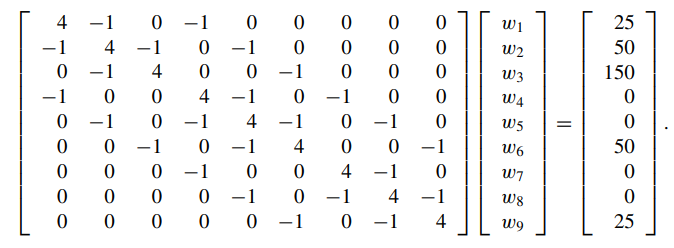

In [ ]:
def adjacency_conductivity_matrix(Nx, Ny, alpha):
    N = Nx * Ny  # Total number of nodes
    A = sp.lil_matrix((N, N))  # Initialize sparse adjacency matrix

    for i in range(Nx):
        for j in range(Ny):
            node = i * Ny + j
            if i > 0:  # Above
                neighbor = (i - 1) * Ny + j
                A[node, neighbor] = 1
            if i < Nx - 1:  # Below
                neighbor = (i + 1) * Ny + j
                A[node, neighbor] = 1
            if j > 0:  # Left
                neighbor = i * Ny + (j - 1)
                A[node, neighbor] = 1
            if j < Ny - 1:  # Right
                neighbor = i * Ny + (j + 1)
                A[node, neighbor] = 1

    I = sp.eye(Nx*Ny, format="csr")
    return (1+4*alpha)*I - alpha*A

In [ ]:
def predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames):
  lr, s = nested_dissection(A, 500)
  order = lr + s
  B = A[order, :][:, order]

  cholesky_factorization = cholesky(B, ordering_method='natural')

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T[order])[np.argsort(order)]
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [ ]:
Nx, Ny = 3, 3                                    # Number of grid points in x and y
alpha = 0.1
T = np.array([25, 50, 150, 0, 0, 50, 0, 0, 25])  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)
A.toarray()

In [ ]:
n_frames = 10
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500, blit=True)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

In [ ]:
Nx, Ny = 200, 200          # Number of grid points in x and y
alpha = 0.1
T = 10*np.random.rand(Nx* Ny)  # Initial temperature distribution
A = adjacency_conductivity_matrix(Nx, Ny, alpha)

In [ ]:
frames = predict_heat_distribution_homemade(A, T, Nx, Ny, n_frames)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='hot', interpolation='nearest')
ax.set_title("Heat Distribution")
plt.colorbar(im, ax=ax)

def update(frame):
    im.set_data(frames[frame])
    ax.set_title(f"Time Step {frame + 1}/{n_frames}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=500)

# Display animation as HTML5 video in Google Colab
video = ani.to_html5_video()
plt.close(fig)  # Avoid duplicate plot output
HTML(video)

### **Task 3 (5 pts):**
Compare computation and memory efficiency of Cholesky using intact matrix with your implementation of Nested Dissection with built-in method.

In [ ]:
def predict_heat_distribution_naive(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A)

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T, ordering_method='natural')
    frames.append(T.reshape((Nx, Ny)))
  return frames

In [ ]:
def predict_heat_distribution(A, T, Nx, Ny, n_frames):
  cholesky_factorization = cholesky(A)

  frames = [T.copy().reshape((Nx, Ny))]

  for _ in tqdm(range(n_frames)):
    # Solve sparse linear system for next time step
    T = cholesky_factorization.solve_A(T)
    frames.append(T.reshape((Nx, Ny)))
  return frames

## Clusterisation of musical notes with FFT and PCA (10 pts)

In [ ]:
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

### Implement FFT via Cooley-Tukey (check lectures) (5 pts)

In [ ]:
def FFT(x):
    """
    1D Cooly-Tukey, for input of size 2**n
    """


    '''
    Replace with your own implementation
    '''

    return fft(x)

### PCA (use SVD library func) (5 pts)

In [ ]:
def calc_PCA(matrix, n_components):
    # as input: matrix (n_samples, n_features)
    # as output: matrix (n_samples, n_features)

    '''
    replace with your own func!
    '''

    from sklearn.decomposition import PCA
    a = PCA(n_components)
    return a.fit_transform(matrix)

### Read files + Utils

In [ ]:
def process_audio(filename):
    samplerate, data = wavfile.read(f'./{filename}.wav')
    if len(data.shape) > 1:
        # convert to mono
        data = data[:, 0]

    data_splitted = []

    w_size = 2048
    for indent in [0, 512, 1024, 1024 + 512]:
        data_i = data[indent:]
        data_i = data_i[:data_i.shape[0] - data_i.shape[0] % w_size]
        n_splits = data_i.shape[0] // w_size
        # print(data.shape)
        data_splitted.append(np.split(data_i, n_splits))

    data_splitted = np.concatenate(data_splitted)


    a = FFT(data_splitted)
    a = a / np.linalg.norm(a, axis=1).reshape(-1, 1)
    return a, [filename] * a.shape[0]

In [ ]:
chunks, labels = [], []

for fl in ['a1', 'b1', 'c1', 'e1', 'f1', 'g1', 'a1s', 'c1s', 'd1s', 'f1s', 'g1s']:
    z, x = process_audio(fl)
    chunks.append(z)
    labels.append(x)



In [ ]:
labels_concat = []
for l in labels:
    labels_concat += l

In [ ]:
chunks_np = np.abs(np.concatenate(chunks))

In [ ]:
chunks_fitted = calc_PCA(chunks_np, 4)

### Visualisation

In [ ]:
colors = {
    'a1': 'red',
    'a1s': 'pink',
    'b1': 'green',
    'c1': 'blue',
    'c1s': 'olive',
    'd1s': 'purple',
    'e1': 'cyan',
    'f1': 'orange',
    'f1s': 'black',
    'g1': 'yellow',
    'g1s': 'blueviolet',

}
color_labels = [colors[d] for d in labels_concat]

In [ ]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 3], color=color_labels)

In [ ]:
plt.scatter(chunks_fitted[:, 0], chunks_fitted[:, 2], color=color_labels)